## はじめに
高速なエッジ保持平滑化フィルタとしてGuidedFilterが広く知られています．この記事では輝度信号に限定したシンプルな実装を紹介します．なお，実装にはRustと[image]("https://github.com/image-rs/image")クレートを用いました．

## やったこと

 * GuidedFilterを用いたエッジ保持平滑化フィルタを実装

## GuidedFilterについて

GuidedFilterはガイド信号$\bf{I}$の１次式で入力信号$\bf{p}$を近似することで出力信号$\bf{q}$を得ます．また，このガイド信号の選択により様々な応用が考案されています．今回紹介するエッジ保持平滑化フィルタはその中の一つです．

それでは，実際に出力信号を得るための方法について述べていきます．まず，$\bf{q}$と$\bf{I}$との関係を以下のように定義します．

$$
\begin{aligned}
q_{i} & = a_{k} I_{i} + b_{k} \ ,\forall i \in \omega_{k} \\ 
\end{aligned}
$$

ここで，$i$は画素のインデックスを，$k$はウィンドウ中心画素のインデックスを，$\omega_{k}$はウィンドウをそれぞれ表します．


次に，$p$と$q$との関係について考えます．ここでノイズ$n$を用いると以下のように表現することができます．

$$
\begin{aligned}
q_{i} & = p_{i} - n_{i} \\
   & = a_{k} I_{i} + b_{k}
\end{aligned}
$$

そして，$q$で$p$をより良く近似するため，以下の評価関数の最小化を考えます．

$$
\begin{aligned}
E\left(a_{k}, b_{k}\right) & = \sum_{i \in \omega_{k}} \left(\left(a_{k}I_{i} + b_{k} - p_{i}\right)^{2} + \epsilon a_{k}^{2}\right) \\
\end{aligned}
$$

この式において，$\epsilon a_{k}^{2}$で表される項は，$a_{k}$の正則化を目的としたものです．この項はリッジ回帰に用いられる正則化項と同様のモチベーションで導入されています．

それでは，$E\left(a_{k}, b_{k}\right)$を$a_{k}$および$b_{k}$で偏微分して最適な$a_{k}$と$b_{k}$を求めていきます．最初に$b_{k}$について考えます．

$$
\begin{aligned}
\frac{\partial}{\partial b_{k}} E\left(a_{k}, b_{k}\right) & = 2\sum_{i \in \omega_{k}} \left(a_{k}I_{i} + b_{k} - p_{i}\right) \\
&= 0 \\
b_{k} &= \frac{1}{\left| \omega_{k} \right|} \sum_{i \in \omega_{k}} p_{i} - \frac{a_{k}}{\left| \omega_{k} \right|}\sum_{i \in \omega_{k}} I_{i}\\
\end{aligned}
$$

ここで，$\bar{p_{k}} = \frac{1}{\left| \omega_{k} \right|} \sum_{i \in \omega_{k}} p_{i}$, $\mu_{k} = \frac{1}{\left| \omega_{k} \right|}\sum_{i \in \omega_{k}} I_{i}$ とすると，

$$
\begin{aligned}
b_{k} &= \bar{p_{k}} - a_{k} \mu_{k} 
\end{aligned}
$$

次に$a_{k}$について考えます．

$$
\begin{aligned}
\frac{\partial}{\partial a_{k}} E\left(a_{k}, b_{k}\right) & = \frac{\partial}{\partial a_{k}} \sum_{i \in \omega_{k}} \left(\left(a_{k}I_{i} + b_{k} - p_{i}\right)^{2} + \epsilon a_{k}^{2}\right)\\
&=   \frac{\partial}{\partial a_{k}} \sum_{i \in \omega_{k}} \left(\left(a_{k}I_{i} + \bar{p_{k}} - a_{k} \mu_{k}  - p_{i}\right)^{2} + \epsilon a_{k}^{2}\right)\\
&=   \frac{\partial}{\partial a_{k}} \sum_{i \in \omega_{k}} \left(\left(a_{k} \left( I_{i}  -\mu_{k}\right) + \bar{p_{k}} - p_{i}\right)^{2} + \epsilon a_{k}^{2}\right)\\
&= 2\sum_{i \in \omega_{k}} \left(\left(a_{k} \left( I_{i}  -\mu_{k}\right) + \bar{p_{k}} - p_{i}\right)\left( I_{i}  -\mu_{k}\right) + \epsilon a_{k}\right)\\
&= 2a_{k} \sum_{i \in \omega_{k}} \left( I_{i}  -\mu_{k}\right)^{2}   - 2 \sum_{i \in \omega_{k}} p_{i}I_{i} + 2 \mu_{k} \sum_{i \in \omega_{k}} p_{i} + 2 \bar{p_{k}} \sum_{i \in \omega_{k}} I_{i} -2 \bar{p_{k}} \mu_{k} \left|\omega_{k}\right| + 2 \epsilon a_{k} \left| \omega_{k} \right| \\
&= 2a_{k} \sigma_{k}^{2} \left|\omega_{k}\right|  - 2 \sum_{i \in \omega_{k}} p_{i}I_{i} + 2 \mu_{k}\bar{p_{k}}\left|\omega_{k}\right|   + 2 \bar{p_{k}} \mu_{k}\left|\omega_{k}\right| -2 \bar{p_{k}} \mu_{k} \left|\omega_{k}\right| + 2 \epsilon a_{k} \left| \omega_{k} \right| \\
&= 0 \\
a_{k} &= \frac{ \frac{1}{\left|\omega_{k}\right|} \sum_{i \in \omega_{k}} p_{i}I_{i} - \bar{p_{k}} \mu_{k} }{\sigma_{k}^{2} + \epsilon }
\end{aligned}
$$

ここで，再度$q_{i}$について考えます．$q_{i}$は$a_{k}$及び$b_{k}$に依存していますが，これらの値はウィンドウ$\omega_{k}$の中心座標$k$に対して変化します．従って，$q_{i}$を一意に定めることはできません．そこで，$q_{i}$に影響を及ぼす$\omega_{k}$対して平均値を計算します．

$$
\begin{aligned}
q_{i} & = \frac{1}{\left|\omega_{i}\right|} \sum_{k \in \omega_{i}} \left(a_{k} I_{i} + b_{k}\right) \\
&= \left(\frac{1}{\left| \omega_{i} \right|} \sum_{k \in \omega_{i}}a_{k} \right)I_{i} + \frac{1}{\left| \omega_{i} \right|} \sum_{k \in \omega_{i}}b_{k} \\
&= \bar{a_{i}} I_{I} + \bar{b_{i}}
\end{aligned}
$$

## Rustによる実装

 それでは，実際にRustでGuidedFilterを実装していきます．今回，以下のクレートを使用します．
 
 * [image]("https://github.com/image-rs/image")
 * [num-traits]("https://crates.io/crates/num-traits")
 * [base64]("https://crates.io/crates/base64")
 
 
 `image` は画像の読み書き及びデータ表現に，`num-traits` は画像データ型から計算用のデータ型への変換に，`base64`はNotebook上への画像出力にそれぞれ用いました．

まず初めに必要なクレートを導入します．

In [52]:
:dep image 
:dep num-traits
:dep base64
//above line is magic for adding crate

use image::{GenericImageView, ImageBuffer, Luma, Pixel, Primitive};
use num_traits::NumCast;

次にNotebook上への画像出力機能を実装します．詳細は[以前の記事]("https://lab.ar90n.net/rust/jupyter/2020/11/15/rust-on-nodebook-with-evcxr-jupyter.html")を参考にしてください．

In [53]:
extern crate image;
extern crate base64;
pub trait EvcxrResult {fn evcxr_display(&self);}
impl EvcxrResult for ImageBuffer<Luma<u8>, Vec<u8>> {
    fn evcxr_display(&self) {
        let mut buffer = Vec::new();
        image::codecs::jpeg::JpegEncoder::new(&mut buffer).encode(&**self, self.width(), self.height(),
            image::ColorType::L8).unwrap();
        let img = base64::encode(&buffer);
        println!("EVCXR_BEGIN_CONTENT image/png\n{}\nEVCXR_END_CONTENT", img);        
    }
}

次にあると便利な雑多な関数を実装します．ここでは，所望のデータ型を`Subpixel`とした`Pixel`型を取得する`cast_subpixel` と スケールを調整した$\epsilon$ を計算する`calc_eps` を実装します．論文中では画像データを$0 \sim 1$に正規化した状態で取り扱っています．今回の実装では，画像データを$0 \sim 255$ の範囲で取り扱うため，`calc_eps` で$\epsilon$の値を適切にスケーリングします．

In [54]:
fn cast_subpixel<S, T>(pixel: &Luma<S>) -> Luma<T>
where
    S: Primitive,
    T: Primitive,
{
    let Luma([data]) = *pixel;
    Luma([NumCast::from(data).unwrap(); 1])
}


fn cals_eps(eps: f64) -> f64 {
    let eps = 255.0 * eps;
    eps * eps
}

次に２次元平滑化処理を行う`mean2d` を実装します．2次元平滑化処理は

1. x方向移動平均フィルタ
1. 転置
1. x方向移動平均フィルタ
1. 転置

という処理で実現しています．

In [55]:
fn mean2d<I, S>(image: &I, r: u32) -> ImageBuffer<Luma<f64>, Vec<f64>>
where
    I: GenericImageView<Pixel = Luma<S>>,
    S: Primitive + 'static,
{
    fn get_luma_as_f64<I, S>(image: &I, x: u32, y: u32) -> f64
    where
        I: GenericImageView<Pixel = Luma<S>>,
        S: Primitive + 'static,
    {
        let Luma(data) = image.get_pixel(x, y);
        NumCast::from(data[0]).unwrap()
    }

    fn calc_mean(head_value: f64, tail_value: f64, r: u32) -> f64 {
        let den = 2.0 * r as f64 + 1.0;
        let num = head_value - tail_value;
        num / den
    }

    fn meand2d_tr<I, S>(image: &I, r: u32) -> ImageBuffer<Luma<f64>, Vec<f64>>
    where
        I: GenericImageView<Pixel = Luma<S>>,
        S: Primitive + 'static,
    {
        let (width, height) = image.dimensions();
        let mut result = ImageBuffer::new(height, width);

        for y in 0..height {
            let mut head_x: u32 = 0;
            let mut mid_x: u32 = 0;
            let mut tail_x: u32 = 0;
            let mut acc_head_x: f64 = 0.0;
            let mut acc_tail_x: f64 = 0.0;

            while mid_x < width {
                if head_x < width {
                    acc_head_x += get_luma_as_f64(image, head_x, y);
                    head_x += 1;
                }
                if r < mid_x {
                    acc_tail_x += get_luma_as_f64(image, tail_x, y);
                    tail_x += 1;
                }
                if r <= head_x {
                    let pixel = Luma([calc_mean(acc_head_x, acc_tail_x, r); 1]);
                    result.put_pixel(y, mid_x, pixel);
                    mid_x += 1;
                }
            }
        }

        result
    }

    meand2d_tr(&meand2d_tr(image, r), r)
}

実際にGuidedFilterの処理を行う関数`guided_filter`です．今回はエッジ保持平滑化フィルタのみを対象としているため，$I = p$（ガイド信号は入力信号と等しい）としています．また，`r`はウィンドウ領域の半径を，`eps`は$\epsilon$をそれぞれ表します．

In [64]:
fn guided_filter<I, S>(image: &I, r: u32, eps: f64) -> ImageBuffer<Luma<u8>, Vec<u8>>
where
    I: GenericImageView<Pixel = Luma<S>>,
    S: Primitive + 'static,
{
    let eps = cals_eps(eps);
    let i = image;
    let mean_i = mean2d(i, r);

    let (w, h) = i.dimensions();
    let ii = ImageBuffer::from_fn(w, h, |x, y| {
        cast_subpixel(&i.get_pixel(x, y)).map(|v: f64| v * v)
    });
    let corr_i = mean2d(&ii, r);

    let var_i = ImageBuffer::from_fn(w, h, |x, y| {
        mean_i
            .get_pixel(x, y)
            .map2(corr_i.get_pixel(x, y), |m, c| c - m * m)
    });

    let a = ImageBuffer::from_fn(w, h, |x, y| {
        var_i.get_pixel(x, y).map_without_alpha(|v| v / (v + eps))
    });

    let b = ImageBuffer::from_fn(w, h, |x, y| {
        mean_i
            .get_pixel(x, y)
            .map2(a.get_pixel(x, y), |m, a| (1.0 - a) * m)
    });

    let mean_a = mean2d(&a, r);
    let mean_b = mean2d(&b, r);

    let q = ImageBuffer::from_fn(w, h, |x, y| {
        let i_v: f64 = {
            let Luma([data]) = i.get_pixel(x, y);
            NumCast::from(data).unwrap()
        };

        mean_a
            .get_pixel(x, y)
            .map2(mean_b.get_pixel(x, y), |a, b| a * i_v + b)
    });
    
    ImageBuffer::from_fn(w, h, |x, y| -> Luma<u8> {
        cast_subpixel(q.get_pixel(x, y))
    })
}

## 実行結果

入力信号は以下のとおりです．

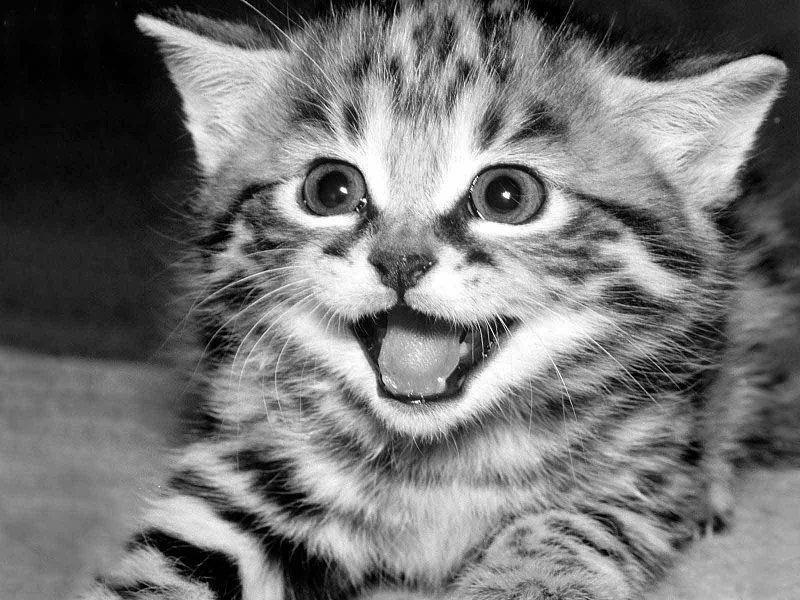

In [68]:
let img = image::open("/assets/img/2021-09-30-simple-guided-filter-rs/media/input.jpg").unwrap().to_luma8();
img

### r=18, eps=0.1^2

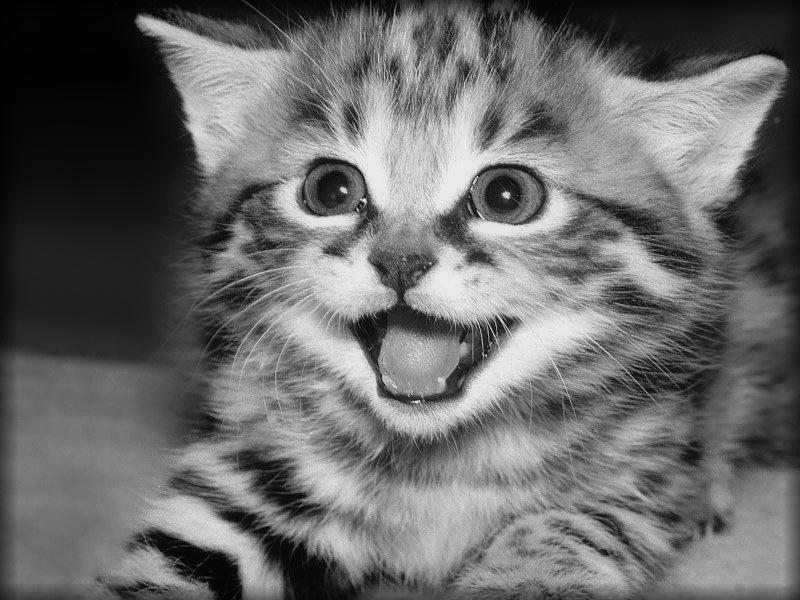

In [69]:
guided_filter(&img, 18, 0.1)

### r=18, eps=0.4^2

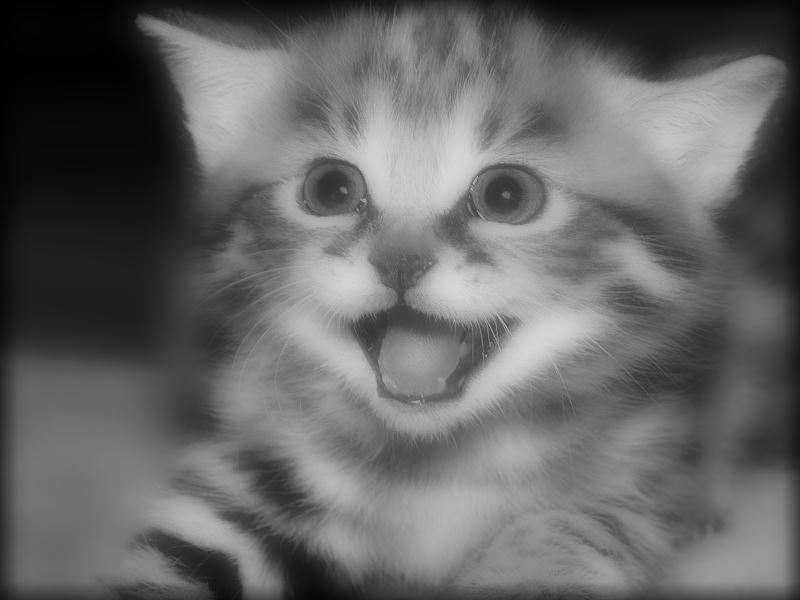

In [70]:
guided_filter(&img, 18, 0.4)

### r=18, eps=0.8^2

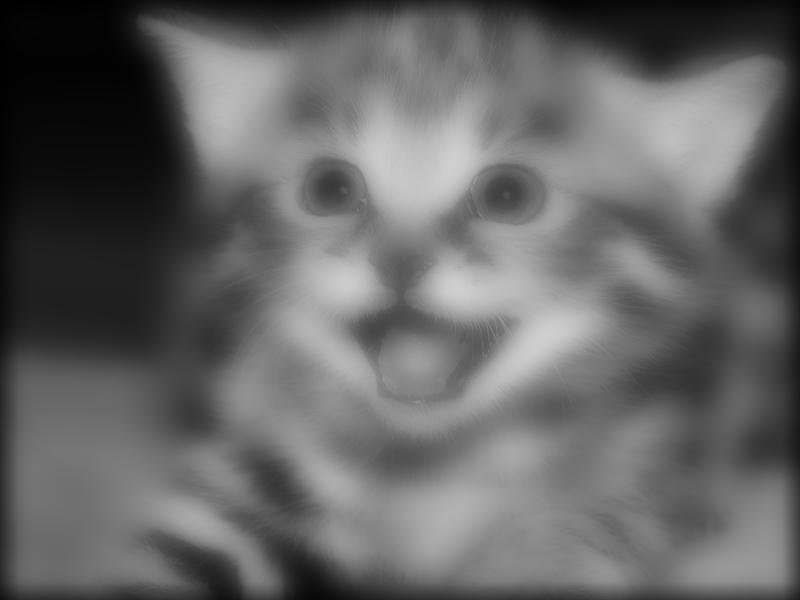

In [71]:
guided_filter(&img, 18, 0.8)

## 参考
* Guided image filtering, He, Kaiming and Sun, Jian and Tang, Xiaoou, IEEE transactions on pattern analysis and machine intelligence